# ICA Example

The goal of this script is to illustrate independent component analysis as a method
suitable for blind source separation. This is done by creating several non-gaussian
signals and mixing them - the unmixing is then done by Hyvarinens standard Fast ICA
algorithm. More details can be found in the publication "Independent component analysis
: algorithms and applications" by A. Hyvärinen, E. Oja, Neural Networks, Volume 13, 
Issues 4–5, 2000,Pages 411-430.

For this, do the following:

    * 1. Definitions and imports
    * 2. Simulate measurements
    * 3. Whiten the data
    * 4. Execute FastICA
    * 5. Plot results

The following entries may be changed to explore the script:

    * sigma_noise         : Quantifies the average magnitude of the noise
    * period              : Determines the amount of signal repetitions
    * n_timesteps         : Determines the number of measurements per signal
                                        
This script is given out as part of the Machine Learning Tutorial during IV2020, Munich. Please consult the slides for some background information regarding motivation and a possible physical setup for this example.

Written by Jemil Butt, Zan Gojcic, ETH Zurich.

 # 1. Definitions and imports ------------------------------------------------

Define the average magnitude of the noise by adjusting $\sigma_{noise}$ and the period of the simulated data by changing the vector $$period=[p_{sine},p_{sawtooth},p_{box}]=[p_1,p_2,p_3].$$ The three different signals $[x_1,x_2,x_3]$ playing a role in this task are sinewaves, sawtooths and squarewaves (see image below).  

Sinewave $x_1(t)=\sin(2\pi p_{1}t)$ $\hspace{4cm}$ Sawtooth $x_2(t)=\operatorname{sawtooth}(2\pi p_{2}t)$ $\hspace{2cm}$ Squarewave $x_3(t)=\operatorname{box}(2\pi p_{3}t)$
![alt text](https://drive.google.com/uc?id=1S3ueFz60A1uBgG6YtGB4oLaVZF7nsH8t)

The goal of Blind source separation (and this specific implmentation of it via the Independent Component Analysis algorithm) is to separate mixtures of non-Gaussian signals into the original underlying signals. The latter ones are also called 'sources' in the BSS-literature. In this example, the sources are the signals recorded in the vector $x_{true}=[x_1,x_2,x_3]^T$ whose components have been illustrated in the image above. The vector $x_{true}$ has only been observed in terms of mixtures $$x_{observed}=A x_{true}+x_{noise}$$
where $A$ is a Matrix of appropriate sizes and $x_{noise}$ is uncorrelated noise. If $A$ were known, $x_{true}$ could be trivially guessed via $\hat{x}_{true}=A^{-1}x_{observed}.$  If however, as typical in BSS, the mixing matrix $A$ is considered to be unknown, it needs to be estimated. If the sources are known to be originating from independent processes, a guess for $A$ might be produced by finding those coefficients $(A)_{ij}=a_{ij}, i,j=1, ... m$ that maximize a measure of stochastic independence of the vector $\hat{x}_{sources}=A^{-1}x_{observed}$.

In [1]:

# 1.1 Import numerical and plotting libraries
import numpy as np
import numpy.matlib as mb
import scipy.signal as signal
import matplotlib.pyplot as plt

# 1.2 Define elementary quantities
n_timesteps=200                         # Discretization density
time=np.linspace(0,1,n_timesteps)       # Independent variable interpreted as time
m=3                                     # Nr of independent components

# 1.3 Set the parameters necessary for simulation
sigma_noise=0.001                       # Quantifies the average magnitude of the noise
period=2*np.pi*np.array([3,4,5])        # Quantifies the amount of signal repetitions

print('Packages imported. The parameters for simulation have been defined and are now \
ready for later use.')


Packages imported. The parameters for simulation have been defined and are now ready for later use.


# 2. Simulate measurements --------------------------------------------------

To arrive at the measurement vectors $x_{observed}$, the simulation of 3 quantities is necessary: The signals $x_{true}$, the noise $x_{noise}$ and the mixing matrix $A$ that are combined according to the equation $$x_{observed}=Ax_{true} + x_{noise}.$$ Whereas for $x_{true}$  the deterministic sine, sawtooth and square signals are chosen, the noise $x_{noise}$ is entirely stochastic and uncorrelated with $(x_{noise})_{ij}\coprod (x_{noise})_{kl}$ for $(i,j)\neq(k,l)$ and $(x_{noise})_{ij}\sim \mathcal{N}(0,\sigma_{noise}^2)$. The mixing matrix $A$ is chosen randomly as well with its entries white noise although a subsequent column-wise scaling is applied that avoids the rows of $x_{observed}$ being of too different magnitudes for illustration purposes. An example of the mixed signals $x_{observed}$ to be split into independent components can be found in the images below. In this example, the randomly chosen mixing matrix is approximately 

$$A\approx\begin{bmatrix} 0.933 &  0.397 & -0.239 \\       -0.320&  -0.885 & -0.952\\ -0.165&  0.245&  0.193 \end{bmatrix}.$$

![alt text](https://drive.google.com/uc?id=1Q_HqJsKl6oL0Sbjm8tXN5op-9MfkrYdJ)
Notice, how non-obvious the presence of sines, sawtooths and squarewaves is and how difficult the intuitive visual estimation of the different source signals would be event by employing this prior knowledge. 

In [2]:

# 2.1 Create covariance matrix of noise

# Define covariance function
def cov_fun_noise(time_1,time_2,sigma_noise):
    covariance=np.power(sigma_noise,2)*int(time_1==time_2)
    return covariance

# Assemble covariance matrices
Cov_mat_noise=np.zeros((n_timesteps,n_timesteps))
for i in range(n_timesteps):
    for j in range(n_timesteps):
        Cov_mat_noise[i,j]=cov_fun_noise(time[i],time[j],sigma_noise)

# 2.3 Simulate independent timeseries

# Define the signals as sines, sawtooths and squares of different repetititon rate        
x_sine=np.sin(time*period[0])
x_triangle=signal.sawtooth(period[1]*time)
x_box=signal.square(time*period[2])

# Simulate some noise to superimpose onto the measurements
x_noise=np.zeros([m,n_timesteps])
for k in range(m):
    x_noise[k,:]=np.random.multivariate_normal(np.zeros([n_timesteps]),Cov_mat_noise)
    
# 2.4 Mix the timeseries together and add noise

# Generate mixing matrix at random
A=np.random.normal(0,1,size=[m,m])
for k in range(m):
    A[:,k]=A[:,k]/np.linalg.norm(A[:,k])
x_true=np.stack((x_sine,x_triangle,x_box),axis=0);

# Mix the signals
x_o=A@(x_true)+x_noise

print('Sine, sawtooth and square signals have been generated, subjected to noise and mixed randomly.')


Sine, sawtooth and square signals have been generated, subjected to noise and mixed randomly.


# 3. Whiten the data --------------------------------------------------------

As a preprocessing step to ICA the data $x_{observed}$ has to be whitened. This consists in two steps, one in which the data is centered and another one in which the data is decorrelated by diagonalizing the the empirical covariance matrix.
$$\begin{align} 1&.\text{Centering  }  &&x_{centered}=x_{observed}-\sum_{k=1}^{n_{timesteps}} x_{observed}(t_k) \\
2&. \text{Decorrelation  }  &&x_{whitened}=S^{-1/2}x_{observed} ~~~\text{where } S=\frac{1}{n_{timesteps}}x_{centered}x_{centered}^T\end{align}$$
The whitened data has mean $0$ and its empirical covariance matrix is the unit matrix $I$. This is due to the fact that $$\frac{1}{n_{timesteps}}S^{-1/2}x_{centered} (S^{-1/2}x_{centered})^T=S^{-1/2} SS^{-1/2}=I.$$
The whitened data $x_{whitened}$ consists of the principal components of the observations $x_{observed}$. Although the principal components are uncorrelated and therefore (in a weak sense) stochastically independent, they are bad estimators for the underlying sources $x_{true}$ as the image below attests.
![alt text](https://drive.google.com/uc?id=1ms3o8lxSK2wAz_QpzZfy6-rncAIDURPS)
Notice that the decorrelation process is not unique and any unitary transformation $W$ applied to $x_{whitened}$ produces another centered and decorrelated process since $WW^T=I$. It is therefore essential that the underlying processes are not Gaussian - otherwise there are infinitely many indistinguishable signal splits that all optimize the objectively correct measure of independence (the correlation).

In [3]:

# 3.1 Subtract the mean
mu=np.mean(x_o,axis=1)
x_o_centered=x_o-np.transpose(mb.repmat(mu,n_timesteps,1))

# 3.2 Diagonalize the covariances
Sigma_emp=(1/n_timesteps)*(x_o_centered@np.transpose(x_o_centered))
U,S,V=np.linalg.svd(Sigma_emp)

Sigma_sqrt=U@np.diag(np.sqrt(S))@np.transpose(V)
Whitening=np.linalg.pinv(Sigma_sqrt)
Dewhitening=Sigma_sqrt

# 3.3 Whiten the data and rename
x_o_whitened=Whitening@x_o_centered
z=x_o_whitened

print('Whitening of the data sucessful. The whitened components correspond to the ones \
identified via PCA')

Whitening of the data sucessful. The whitened components correspond to the ones identified via PCA


# 4. Execute FastICA --------------------------------------------------------

ICA now tries to find that unitary matrix $W$ that minimizes some additional measure of dependence on $x_{sources~guess}=Wx_{whitened}$. Since $W$ is unitary, $x_{sources ~ guess}$ is uncorrelated. There are several different measures of dependence whose minimization corresponds to different distributional assumptions on the data. One of the most common ones is the  used in the Fast ICA algorithm proposed by Hyvärinen and Oja.

They approximate the negentropy (a entropy-based distance measure on probability distributions) by the function $G=\log \cosh (u)$ and maximize it in an iteration that involves its first two derivates $$g=\tanh(u) \text{ and } \partial_u g = 1-\tanh^2(u).$$

The iteration for $W$ consists in a sequence of intermittent maximizations of $G$ with respect to $W$ and orthogonalizations that are listed in the pseudocode below.

* 1. Initialize $W$ randomly
* 2. Calculate $zw=Wx_{whitened}$ 
* 3. Update $W=\frac{1}{n_{timesteps}}g(zw)x^T_{whitened} -\operatorname{diag}\left(\sum_{k=1}^{n_{timesteps}}\partial_{u}g(zw)\right)W$

where steps 2 and 3 are to be repeated until convergence. The result of this processing are guesses for the independent components that are calculated as $x_{source ~ guess}=Wx_{whitened}$.

In [4]:

# 4.1 Define function for decorrelating a Matrix
def Decorrelate(Matrix):
    U,S,V=np.linalg.svd(Matrix)
    Decorr_mat=(U@np.linalg.pinv(np.diag(S))@U.T)@Matrix
    return Decorr_mat

# 4.2 Initialize W and define derivatives of contrast function
k=1 
delta=1
n_iter=100                      # Maximum number of iterations
W=np.random.normal(0,1,[m,m])   # Random initialization

g=lambda zw:np.tanh(zw)                         # Derivative of contrast function
g_prime=lambda zw: 1-np.power(np.tanh(zw),2)    # Second derivative

# 4.3 Iterate over W to minimize entropy
while delta >10**-6 and k<n_iter:
    W_old=W
    zw_prod=W@z
    W=(1/n_timesteps)*(g(zw_prod)@z.T)-np.diag(np.mean(g_prime(zw_prod),1))@W
    W=Decorrelate(W)
    
    # Update optimization progress
    delta=np.max(W-W_old)
    k+=1  
    print('Iteration nr {} with a parameter change of max {}' .format(k,delta))

# 4.4 Reassemble signal guess
x_sources_guess=W@z

print('Independent component analysis carried out. The resulting components are maximally \
independent as measured by (some quantity related to) the entropy.')

Iteration nr 2 with a parameter change of max 0.85900710173818
Iteration nr 3 with a parameter change of max 0.11982026327395662
Iteration nr 4 with a parameter change of max 0.008146156032170948
Iteration nr 5 with a parameter change of max 0.0005149906871976251
Iteration nr 6 with a parameter change of max 3.4351529427323335e-05
Iteration nr 7 with a parameter change of max 2.2218410415941747e-06
Iteration nr 8 with a parameter change of max 1.4557734917541865e-07
Independent component analysis carried out. The resulting components are maximally independent as measured by (some quantity related to) the entropy.


# 5. Plot results -----------------------------------------------------------

Illustrate the ground, truth $x_{true}$, measured data $x_{observed}$, and the inference process delivering estimates for $x_{source}$ via a whitening step and subsequent iterative maximization of joint entropy. Compare the PCA and ICA results.

Text(0, 0.5, 'Function value')

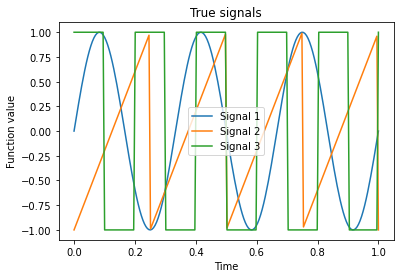

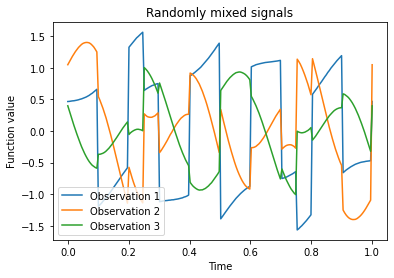

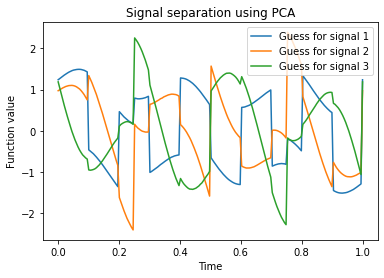

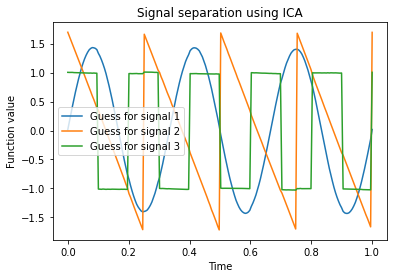

In [5]:

# 5.1 Figures showing the mixture process
# Ground truth
plt.figure(1)
plt.plot(time,x_true.T)
plt.title('True signals')
plt.legend(['Signal 1', 'Signal 2', 'Signal 3'])
plt.xlabel('Time')
plt.ylabel('Function value')

# Mixed components
plt.figure(2)
plt.plot(time,x_o.T)
plt.title('Randomly mixed signals')
plt.legend(['Observation 1', 'Observation 2', 'Observation 3'])
plt.xlabel('Time')
plt.ylabel('Function value')

# 5.2 Figure 3 showing the result of PCA
plt.figure(3)
plt.plot(time,z.T)
plt.title('Signal separation using PCA')
plt.legend(['Guess for signal 1', 'Guess for signal 2', 'Guess for signal 3'])
plt.xlabel('Time')
plt.ylabel('Function value')


# 5.3 Figure 4 showing the demixed components
plt.figure(4)
plt.plot(time,x_sources_guess.T)
plt.title('Signal separation using ICA')
plt.legend(['Guess for signal 1', 'Guess for signal 2', 'Guess for signal 3'])
plt.xlabel('Time')
plt.ylabel('Function value')
